Creating comparative OSMnx stats tables for neighborhood pairs. 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In [1]:
import pandas as pd
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#COMMUTE MODE 

# Highest % commute by transit (except taxi)
s_transit = 'Sindang 5(o)-dong, Jung-gu, Seoul, 04578, South Korea'
l_transit =  'Westlake, Los Angeles, Los Angeles County, California, United States'
# Highest % commute by car
s_car = 'Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea'
l_car = 'Norwalk, Los Angeles County, California, United States'


# RIDERSHIP 
# LRT station with the highest ridership 
s_lrt = 'Seocho-dong, Seocho-gu, Seoul, South Korea'
l_lrt = 'Downtown, Los Angeles, Los Angeles County, California, United States'
##what happens when point data is used? 
 
# DEMAND/NEED 
# Highest population density 
s_popdense = 'Jungang-dong, Seoul, South Korea'
l_popdense = 'Koreatown, Los Angeles, CA, USA'

# Highest job density
s_jobdense = 'Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07380, South Korea'
l_jobdense = 'Burbank, Los Angeles County, California, United States'

Create neighborhood list dataframe:

In [3]:
from pandas import DataFrame

place_list = [ 
                  s_transit, l_transit, 
                  s_car, l_car, 
                  s_lrt, l_lrt, 
                 #s-brt, l-brt
                  s_popdense, l_popdense,
                  s_jobdense, l_popdense
                ]

place_df = DataFrame(place_list,columns=['Neighborhood Name'])
place_df

,Neighborhood Name
0,"Sindang 5(o)-dong, Jung-gu, Seoul, 04578, Sout..."
1,"Westlake, Los Angeles, Los Angeles County, Cal..."
2,"Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, So..."
3,"Norwalk, Los Angeles County, California, Unite..."
4,"Seocho-dong, Seocho-gu, Seoul, South Korea"
5,"Downtown, Los Angeles, Los Angeles County, Cal..."
6,"Jungang-dong, Seoul, South Korea"
7,"Koreatown, Los Angeles, CA, USA"
8,"Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07..."
9,"Koreatown, Los Angeles, CA, USA"


Creating dataframes for neighborhood pairs: 

In [4]:
places = {'Seoul': [s_transit, s_car, s_lrt, s_popdense, s_jobdense],
        'Los Angeles': [l_transit, l_car, l_lrt, l_popdense, l_jobdense]
        }
 
                
place_df_2 = pd.DataFrame(places, columns = ['Seoul','Los Angeles'], index=['Highest % Commute by Transit','Highest % Commute by Car','Highest Ridership','Population Dense', 'Job Dense'])
place_df_2 

,Seoul,Los Angeles
Highest % Commute by Transit,"Sindang 5(o)-dong, Jung-gu, Seoul, 04578, Sout...","Westlake, Los Angeles, Los Angeles County, Cal..."
Highest % Commute by Car,"Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, So...","Norwalk, Los Angeles County, California, Unite..."
Highest Ridership,"Seocho-dong, Seocho-gu, Seoul, South Korea","Downtown, Los Angeles, Los Angeles County, Cal..."
Population Dense,"Jungang-dong, Seoul, South Korea","Koreatown, Los Angeles, CA, USA"
Job Dense,"Singil 3(sam)-dong, Yeongdeungpo-gu, Seoul, 07...","Burbank, Los Angeles County, California, Unite..."


# Call OSMnx 

###### FIGURE OUT LATER: Create dictionary to define variables for each place name 

https://stackoverflow.com/questions/52751674/how-to-use-exec-to-assign-list-to-variable-according-to-dictionary-in-python3

https://stackoverflow.com/questions/5036700/how-can-you-dynamically-create-variables-via-a-while-loop

a = {}
k = 0
while k < 10:
    <dynamically create key> 
    key = ...
    <calculate value> 
    value = ...
    a[key] = value 
    k += 1

Meanwhile I will create these maps manually. 

###### FOR EACH NEIGHBORHOOD PAIR: CHANGE THE LA_neighborhood and Seoul_neighborhood AND 'RUN ALL BELOW' 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In [5]:
# configure the place, network type, trip times, and travel speed
LA_n = 'Westlake, Los Angeles, CA, USA'
Seoul_n = 'Sindang 5(o)-dong, Seoul, South Korea'
network_type = 'walk' 
distance = 1000 

In [6]:
def configure_pair (place1, place2, networktype, distance):    

# NEED TO CALL GRAPH_FROM_PLACE TO FIND CENTER NODE

    # download neighborhood street network
    global n1_place
    global n2_place
    n1_place = ox.graph_from_place(place1, network_type = networktype)
    n2_place = ox.graph_from_place(place2, network_type = networktype)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    global n1_place_crs 
    global n2_place_crs 
    n1_place_crs = ox.project_graph(n1_place, to_crs='epsg:3857') 
    n2_place_crs = ox.project_graph(n2_place, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    global n1_node_place
    global n2_node_place
    global n1_edge_place
    global n2_edge_place
    n1_node_place, n1_edge_place = ox.graph_to_gdfs(n1_place_crs) 
    n2_node_place, n2_edge_place = ox.graph_to_gdfs(n2_place_crs) 
    
    # get the bounding box coordinates
    n1_minx, n1_miny, n1_maxx, n1_maxy = n1_node_place.geometry.total_bounds
    n2_minx, n2_miny, n2_maxx, n2_maxy = n2_node_place.geometry.total_bounds
    
    # calculate the centroid
    n1_centroid_x = (n1_maxx-n1_minx)/2 + n1_minx
    n1_centroid_y = (n1_maxy-n1_miny)/2 + n1_miny 

    n2_centroid_x = (n2_maxx-n2_minx)/2 + n2_minx
    n2_centroid_y = (n2_maxy-n2_miny)/2 + n2_miny 
    
    # use osmnx's get_nearest_node command to get the id for the nearest node
    global n1_center_node
    n1_center_node = ox.get_nearest_node(n1_place_crs, 
                                  (n1_centroid_y, n1_centroid_x), 
                                  method = 'euclidean') 
    global n2_center_node 
    n2_center_node = ox.get_nearest_node(n2_place_crs, 
                                  (n2_centroid_y,n2_centroid_x), 
                                  method = 'euclidean') 
    
    #NEW:
    #define a tuple for the coordinates of each neighborhood's central node 
    n1_lat = n1_place.nodes[n1_center_node]['y']
    n1_long = n1_place.nodes[n1_center_node]['x']
    n1_tuple = (n1_lat, n1_long)
    
    n2_lat = n2_place.nodes[n2_center_node]['y']
    n2_long = n2_place.nodes[n2_center_node]['x']
    n2_tuple = (n2_lat, n2_long)
    
    
# NOW THAT WE FOUND THE CENTER NODE, CALL GRAPH_FROM_POINT 
     # download neighborhood street network
    global n1_pt
    global n2_pt
    n1_pt = ox.graph.graph_from_point(n1_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    n2_pt = ox.graph.graph_from_point(n2_tuple, dist = distance, dist_type='bbox', network_type = networktype, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    
    # project downloaded network data to Web Mercator (measurements are in meters)
    n1_pt = ox.project_graph(n1_pt, to_crs='epsg:3857') 
    n2_pt = ox.project_graph(n2_pt, to_crs='epsg:3857')
    
    # convert nodes and edges to two separate geodataframes 
    global n1_node_pt
    global n2_node_pt
    global n1_edge_pt
    global n2_edge_pt   
    n1_node_pt, n1_edge_pt = ox.graph_to_gdfs(n1_pt) 
    n2_node_pt, n2_edge_pt = ox.graph_to_gdfs(n2_pt) 
    

In [7]:
configure_pair(Seoul_n, LA_n, network_type, distance)

Map the pair! 

Text(0.5, 1.0, 'Westlake, Los Angeles, CA, USA (walk, 1000 m from center)')

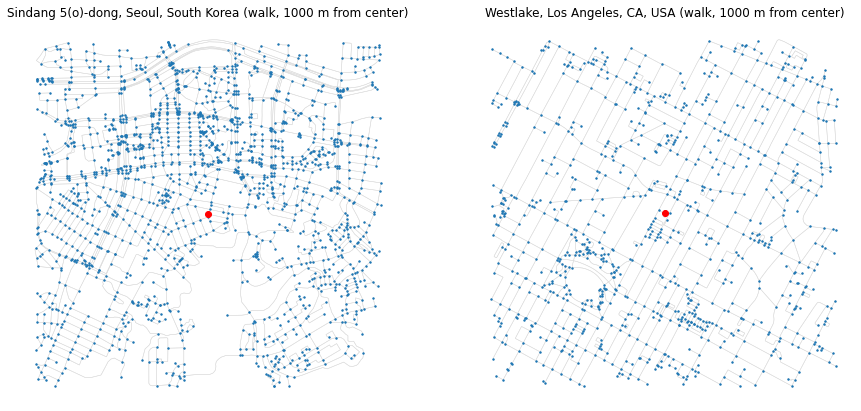

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
ax1, ax2 = axs
    
# Neighborhood 1 
n1_edge_pt.plot(ax = ax1,
                            linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10
                            )  
# add all nodes to ax
n1_node_pt.plot(ax=ax1, 
                   markersize=2, 
                   zorder=20)
    
# add the center node in red also to ax
n1_node_place.loc[[n1_center_node]].plot(ax = ax1,
                                      color='r', 
                                      zorder=30)
    
ax1.axis("off")
ax1.set_title(Seoul_n + " (" + network_type + ", " + str(distance) + " m from center)")



# Neighborhood 2 
n2_edge_pt.plot(linewidth = 0.5, 
                            edgecolor='gainsboro',
                            zorder=10,
                            ax = ax2)  
# add all nodes to ax
n2_node_pt.plot(ax=ax2, 
                   markersize=2, 
                   zorder=20)
    
# add the center node in red also to ax
n2_node_place.loc[[n2_center_node]].plot(ax=ax2,
                                      color='r', 
                                      zorder=30)

ax2.axis("off")
ax2.set_title(LA_n + " (" + network_type + ", " + str(distance) + " m from center)")


# Nodes and Edges

Neighborhood 1: 

In [9]:
print("Nodes & Edges of " + Seoul_n)
n1_node_pt.head()

Nodes & Edges of Sindang 5(o)-dong, Seoul, South Korea


,y,x,osmid,lon,lat,highway,geometry
414685876,4.518406e+06,1.414093e+07,414685876,127.030096,37.566780,NaN,POINT (14140925.591 4518405.875)
436827118,4.516695e+06,1.413980e+07,436827118,127.019994,37.554596,NaN,POINT (14139801.108 4516694.842)
436827125,4.517009e+06,1.413977e+07,436827125,127.019729,37.556834,NaN,POINT (14139771.598 4517009.046)
436827127,4.517180e+06,1.413970e+07,436827127,127.019057,37.558049,NaN,POINT (14139696.780 4517179.702)
436827130,4.517226e+06,1.413968e+07,436827130,127.018890,37.558380,NaN,POINT (14139678.156 4517226.197)


Neighborhood 2: 

In [10]:
print("Nodes & Edges of " + LA_n)
n2_node_pt.head()

Nodes & Edges of Westlake, Los Angeles, CA, USA


,y,x,osmid,highway,lon,lat,geometry
18166944,4.037759e+06,-1.316579e+07,18166944,traffic_signals,-118.270308,34.066679,POINT (-13165790.407 4037758.891)
21300247,4.036588e+06,-1.316641e+07,21300247,traffic_signals,-118.275888,34.057963,POINT (-13166411.625 4036587.645)
21300249,4.035921e+06,-1.316518e+07,21300249,traffic_signals,-118.264867,34.052999,POINT (-13165184.784 4035920.706)
21306066,4.036381e+06,-1.316603e+07,21306066,traffic_signals,-118.272496,34.056422,POINT (-13166033.996 4036380.614)
21306068,4.036799e+06,-1.316630e+07,21306068,traffic_signals,-118.274881,34.059533,POINT (-13166299.538 4036798.590)


# Street Grid Statistics  

OSMnx documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html 


## basic_stats & extended_stats

In [11]:
def pair_basicstats(n1, n2, distance):
    n1_dict = ox.basic_stats(n1, area = (distance*2)**2, circuity_dist= 'euclidean')
    n2_dict = ox.basic_stats(n2, area = (distance*2)**2, circuity_dist= 'euclidean')
    
    n1_df = pd.DataFrame.from_dict(n1_dict)
    n2_df = pd.DataFrame.from_dict(n2_dict)

    print("Basic Stats for "+ n1)
    return(n1_df)
    print("Basic Stats for "+ n2)
    return(n2_df)

In [12]:
def pair_extstats(n1, n2, distance, circuitydistance):
    n1_dict = ox.stats.extended_stats(n1, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
    n2_dict = ox.stats.extended_stats(n2, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
    
    n1_df = pd.DataFrame.from_dict(n1_dict)
    n2_df = pd.DataFrame.from_dict(n2_dict)

    print("Extended Stats for "+ n1)
    return(n1_df)
    print("Extended Stats for "+ n2)
    return(n2_df)
 

## Basic Stats

Documentation for ox.basic_stats(): https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats

##### Seoul Neighborhood Basic Stats

In [13]:
s_basicstats_dict = ox.basic_stats(n1_pt, area = (distance*2)**2, circuity_dist='euclidean')
print("Basic Stats for "+ Seoul_n)
s_basicstats_dict

Basic Stats for Sindang 5(o)-dong, Seoul, South Korea


{'n': 1799,
 'm': 5270,
 'k_avg': 5.858810450250139,
 'intersection_count': 1540,
 'streets_per_node_avg': 3.0038910505836576,
 'streets_per_node_counts': {0: 0,
  1: 259,
  2: 0,
  3: 1033,
  4: 492,
  5: 14,
  6: 0,
  7: 0,
  8: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.14396887159533073,
  2: 0.0,
  3: 0.5742078932740411,
  4: 0.27348526959421904,
  5: 0.007782101167315175,
  6: 0.0,
  7: 0.0,
  8: 0.0005558643690939411},
 'edge_length_total': 252181.2700000011,
 'edge_length_avg': 47.85223339658465,
 'street_length_total': 126090.63499999998,
 'street_length_avg': 47.85223339658443,
 'street_segments_count': 2635,
 'node_density_km': 449.75,
 'intersection_density_km': 385.0,
 'edge_density_km': 63045.317500000274,
 'street_density_km': 31522.658749999995,
 'circuity_avg': 0.8424904901722413,
 'self_loop_proportion': 0.0015180265654648956,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

##### LA Neighborhood Basic Stats 

In [14]:
l_basicstats_dict = ox.basic_stats(n2_pt, area = (distance*2)**2, circuity_dist='euclidean')
print("Basic Stats for "+ LA_n)
l_basicstats_dict

Basic Stats for Westlake, Los Angeles, CA, USA


{'n': 904,
 'm': 2506,
 'k_avg': 5.54424778761062,
 'intersection_count': 768,
 'streets_per_node_avg': 2.8860619469026547,
 'streets_per_node_counts': {0: 0, 1: 136, 2: 0, 3: 600, 4: 167, 5: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1504424778761062,
  2: 0.0,
  3: 0.6637168141592921,
  4: 0.1847345132743363,
  5: 0.0011061946902654867},
 'edge_length_total': 163040.7079999998,
 'edge_length_avg': 65.0601388667198,
 'street_length_total': 81520.35400000004,
 'street_length_avg': 65.0601388667199,
 'street_segments_count': 1253,
 'node_density_km': 226.0,
 'intersection_density_km': 192.0,
 'edge_density_km': 40760.17699999995,
 'street_density_km': 20380.08850000001,
 'circuity_avg': 0.8764415670113075,
 'self_loop_proportion': 0.00558659217877095,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

Ok so what is a dict... 

From documentation: 

"The Graph class uses a dict-of-dict-of-dict data structure. The outer dict (node_dict) holds adjacency information keyed by node. The next dict (adjlist_dict) represents the adjacency information and holds edge data keyed by neighbor. The inner dict (edge_attr_dict) represents the edge data and holds edge attribute values keyed by attribute names. 
Each of these three dicts can be replaced in a subclass by a user defined dict-like object. In general, the dict-like features should be maintained but extra features can be added. To replace one of the dicts create a new graph class by changing the class(!) variable holding the factory for that dict-like structure. The variable names are node_dict_factory, node_attr_dict_factory, adjlist_inner_dict_factory, adjlist_outer_dict_factory, edge_attr_dict_factory and graph_attr_dict_factory."


Didn't quite understand, so I googled it...  

"NetworkX uses dicts to store the nodes and neighbors in a graph."

"Graph—Undirected graphs with self loops"*

Source: https://networkx.org/documentation/stable/reference/classes/index.html#basic-graph-types


Eh I'm not comfortable with dicts so I'm going to convert Westlake's network stats to a dataframe. 
Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html 


In [15]:
s_basicstats_df = pd.DataFrame.from_dict(s_basicstats_dict)
print("Basic Stats for "+ Seoul_n)
s_basicstats_df

Basic Stats for Sindang 5(o)-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
1,1799,5270,5.85881,1540,3.003891,259,0.143969,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
2,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
3,1799,5270,5.85881,1540,3.003891,1033,0.574208,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
4,1799,5270,5.85881,1540,3.003891,492,0.273485,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
5,1799,5270,5.85881,1540,3.003891,14,0.007782,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
6,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
7,1799,5270,5.85881,1540,3.003891,0,0.000000,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None
8,1799,5270,5.85881,1540,3.003891,1,0.000556,252181.27,47.852233,126090.635,47.852233,2635,449.75,385.0,63045.3175,31522.65875,0.84249,0.001518,None,None


In [16]:
l_basicstats_df = pd.DataFrame.from_dict(l_basicstats_dict)
print("Basic Stats for "+ Seoul_n)
l_basicstats_df

Basic Stats for Sindang 5(o)-dong, Seoul, South Korea


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
0,904,2506,5.544248,768,2.886062,0,0.000000,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
1,904,2506,5.544248,768,2.886062,136,0.150442,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
2,904,2506,5.544248,768,2.886062,0,0.000000,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
3,904,2506,5.544248,768,2.886062,600,0.663717,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
4,904,2506,5.544248,768,2.886062,167,0.184735,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None
5,904,2506,5.544248,768,2.886062,1,0.001106,163040.708,65.060139,81520.354,65.060139,1253,226.0,192.0,40760.177,20380.0885,0.876442,0.005587,None,None


## Extended Stats

In [17]:
%%time 
s_extstats_dict = ox.stats.extended_stats(n1_pt, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
s_extstats_dict

CPU times: user 585 ms, sys: 2.92 ms, total: 588 ms
Wall time: 588 ms


{'avg_neighbor_degree': {414685876: 4.0,
  436827118: 2.75,
  436827125: 3.0,
  436827127: 3.0,
  436827130: 3.0,
  436827131: 2.3333333333333335,
  436827146: 3.5,
  436827151: 3.75,
  436830067: 3.75,
  436832364: 2.5,
  436832366: 3.0,
  436833090: 4.0,
  436833098: 3.75,
  436833099: 4.0,
  436833102: 3.6666666666666665,
  436833104: 4.0,
  436836475: 3.3333333333333335,
  436836479: 3.0,
  436839601: 4.0,
  436839610: 2.3333333333333335,
  436839611: 3.0,
  436840037: 3.3333333333333335,
  436840048: 3.3333333333333335,
  436840063: 3.0,
  436840064: 3.0,
  436842623: 3.25,
  436864111: 3.3333333333333335,
  436864114: 2.6666666666666665,
  436864119: 3.25,
  436864128: 3.5,
  436864130: 3.3333333333333335,
  436864134: 3.6666666666666665,
  436864145: 3.6666666666666665,
  436864147: 4.0,
  436865877: 3.3333333333333335,
  436865879: 4.0,
  436875635: 3.3333333333333335,
  436875643: 3.0,
  436875644: 2.3333333333333335,
  436875645: 3.5,
  436875646: 3.3333333333333335,
  436877

In [18]:
%%time 
s_extstats_df = pd.DataFrame.from_dict(s_extstats_dict)
print("Extended Stats for "+ Seoul_n)
s_extstats_df 

Extended Stats for Sindang 5(o)-dong, Seoul, South Korea
CPU times: user 15.1 ms, sys: 1.02 ms, total: 16.1 ms
Wall time: 14.4 ms


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min
414685876,4.000000,3.214476,0.199384,0.122361,0.004449,0.003259,0.000000,0.02924,0.000000,0.001554,0.000491,2858053233,0.00204,8481495951,0.000097
436827118,2.750000,3.214476,0.023542,0.122361,0.004449,0.003259,0.166667,0.02924,0.004726,0.001554,0.001028,2858053233,0.00204,8481495951,0.000097
436827125,3.000000,3.214476,0.028908,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000804,2858053233,0.00204,8481495951,0.000097
436827127,3.000000,3.214476,0.025274,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000871,2858053233,0.00204,8481495951,0.000097
436827130,3.000000,3.214476,0.063693,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000509,2858053233,0.00204,8481495951,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508576418,3.000000,3.214476,0.008774,0.122361,0.001112,0.003259,0.000000,0.02924,0.000000,0.001554,0.000407,2858053233,0.00204,8481495951,0.000097
8508576420,2.333333,3.214476,0.013976,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000557,2858053233,0.00204,8481495951,0.000097
8508576424,3.000000,3.214476,0.012988,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000749,2858053233,0.00204,8481495951,0.000097
8509753483,3.666667,3.214476,0.069107,0.122361,0.003337,0.003259,0.333333,0.02924,0.013840,0.001554,0.000604,2858053233,0.00204,8481495951,0.000097


In [22]:
%%time 
s_extstats_df = pd.DataFrame.from_dict(s_extstats_dict)
print("Extended Stats for "+ Seoul_n)
s_extstats_df

Extended Stats for Sindang 5(o)-dong, Seoul, South Korea
CPU times: user 9.54 ms, sys: 69 µs, total: 9.61 ms
Wall time: 7.97 ms


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min
414685876,4.000000,3.214476,0.199384,0.122361,0.004449,0.003259,0.000000,0.02924,0.000000,0.001554,0.000491,2858053233,0.00204,8481495951,0.000097
436827118,2.750000,3.214476,0.023542,0.122361,0.004449,0.003259,0.166667,0.02924,0.004726,0.001554,0.001028,2858053233,0.00204,8481495951,0.000097
436827125,3.000000,3.214476,0.028908,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000804,2858053233,0.00204,8481495951,0.000097
436827127,3.000000,3.214476,0.025274,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000871,2858053233,0.00204,8481495951,0.000097
436827130,3.000000,3.214476,0.063693,0.122361,0.003337,0.003259,0.000000,0.02924,0.000000,0.001554,0.000509,2858053233,0.00204,8481495951,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8508576418,3.000000,3.214476,0.008774,0.122361,0.001112,0.003259,0.000000,0.02924,0.000000,0.001554,0.000407,2858053233,0.00204,8481495951,0.000097
8508576420,2.333333,3.214476,0.013976,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000557,2858053233,0.00204,8481495951,0.000097
8508576424,3.000000,3.214476,0.012988,0.122361,0.003337,0.003259,0.333333,0.02924,0.033191,0.001554,0.000749,2858053233,0.00204,8481495951,0.000097
8509753483,3.666667,3.214476,0.069107,0.122361,0.003337,0.003259,0.333333,0.02924,0.013840,0.001554,0.000604,2858053233,0.00204,8481495951,0.000097


In [21]:
%%time 
l_extstats_df = pd.DataFrame.from_dict(l_extstats_dict)
print("Extended Stats for "+ LA_n)
l_extstats_df

Extended Stats for Westlake, Los Angeles, CA, USA
CPU times: user 7.44 ms, sys: 1.02 ms, total: 8.46 ms
Wall time: 7.07 ms


,avg_neighbor_degree,avg_neighbor_degree_avg,avg_weighted_neighbor_degree,avg_weighted_neighbor_degree_avg,degree_centrality,degree_centrality_avg,clustering_coefficient,clustering_coefficient_avg,clustering_coefficient_weighted,clustering_coefficient_weighted_avg,pagerank,pagerank_max_node,pagerank_max,pagerank_min_node,pagerank_min
18166944,3.500000,2.991962,0.030830,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.002029,122592367,0.002637,2118274656,0.000213
21300247,3.000000,2.991962,0.094684,0.067393,0.008859,0.00614,0.166667,0.036799,0.019494,0.002812,0.000773,122592367,0.002637,2118274656,0.000213
21300249,3.500000,2.991962,0.031206,0.067393,0.004430,0.00614,0.000000,0.036799,0.000000,0.002812,0.001083,122592367,0.002637,2118274656,0.000213
21306066,3.500000,2.991962,0.038870,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.001965,122592367,0.002637,2118274656,0.000213
21306068,3.250000,2.991962,0.037148,0.067393,0.008859,0.00614,0.000000,0.036799,0.000000,0.002812,0.001747,122592367,0.002637,2118274656,0.000213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460152014,3.000000,2.991962,0.113188,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000783,122592367,0.002637,2118274656,0.000213
8460152015,3.000000,2.991962,0.112580,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000816,122592367,0.002637,2118274656,0.000213
8460152016,3.333333,2.991962,0.131907,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.000791,122592367,0.002637,2118274656,0.000213
8460159517,2.666667,2.991962,0.035285,0.067393,0.006645,0.00614,0.000000,0.036799,0.000000,0.002812,0.001761,122592367,0.002637,2118274656,0.000213


****FOR EACH NEIGHBORHOOD PAIR: RUN ALL ABOVE AFTER CHANGING NEIGHBORHOODS FOR LA_n and Seoul_n ****


# Combined Tables 

From here, write unique code to store each neighborhood pair's comparative basic stats table in a variable! 

## Highest % Commute by Transit: Sindang 5 and Westlake

Okay first let's take a look at the basic_stats dataframes: 

In [ ]:
print(Seoul_n)
display(s_basicstats_df)

print(LA_n)
display(l_basicstats_df)

Not sure why clean_intersection_count (= number of intersections in street
network, merging complex ones into single points) and 
clean_intersection_density_km (= clean_intersection_count divided
by area in square kilometers) are empty... when the

Looks like streets per node *count* and streets per node *proportion* vary with each row. 

From OSMnx documentation: 

**Average streets per node:** Mean number of physical streets that emanate from
each node (intersections and dead-ends)

**Counts of streets per node:** A dictionary with keys = the number of streets
emanating from the node, and values = the number of nodes with this number

**Proportions of streets per node:** A dictionary, same as above, but represents a
proportion of the total, rather than raw counts

So do we want to take the average of these columns if we are interested in the count or proportion of streets:node? 

Whatever, we'll just use the average streets per node data. We feel comfortable dropping the redundant rows as well as the streets_per_node_counts and streets_per_node_proportion columns. 

In [ ]:
s_basicstats_df = s_basicstats_df.drop([1, 2, 3, 4, 5]).copy()
l_basicstats_df = l_basicstats_df.drop([1, 2, 3, 4, 5]).copy() 
display(s_basicstats_df, l_basicstats_df)

In [ ]:
s_basicstats_df = s_basicstats_df.drop(columns="streets_per_node_counts").copy()
s_basicstats_df = s_basicstats_df.drop(columns="streets_per_node_proportion").copy() 

l_basicstats_df = l_basicstats_df.drop(columns="streets_per_node_counts").copy()
l_basicstats_df = l_basicstats_df.drop(columns="streets_per_node_proportion").copy() 

display(s_basicstats_df, l_basicstats_df)

START HERE: MANUALLY CALCULATE THE MISSING BASIC STATS! 

CHANGE BUT KEEP THIS CODE: 

Now I'm going to add the Sadang values as the 2nd row (index = 1) to the Westlake dataframe: 

In [ ]:
frames = [westlake_pd, sadang4_pd]
compare_stats = pd.concat(frames)
compare_stats

Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html 

Renaming the index for the City name: 

In [ ]:
compare_stats_test = compare_stats.rename(index={0: 'Westlake', 1:'Sadang 4-dong'})
compare_stats_test

Source: https://note.nkmk.me/en/python-pandas-dataframe-rename/#:~:text=source%3A%20pandas_dataframe_rename.py-,Rename%20column%20%2F%20index%3A%20rename(),change%20column%20%2F%20index%20name%20individually.&text=Specify%20the%20original%20name%20and,index%20is%20for%20index%20name.

I may want to change column names later, but will hold off till Shinah and I decide which stats to keep. 
OSMnx basic_stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html 
list(compare_stats_test)
compare_stats_test.columns =

Alright finally I want to switch the columns and rows for this graph so it fits onto our slides. 

The transpose function does change all values to objects though, which may cause problems in the future? 
Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html 